In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0, resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import re
from PIL import Image
from tqdm import tqdm

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_path = '/content/drive/My Drive/adversarial_mnist'
weights_dir = f'{base_path}/model_weights'
adv_dir = f'{base_path}/large_adversarial_examples'
external_data_path = f'{base_path}/external_dataset/test'

if not os.path.exists(adv_dir):
    os.makedirs(adv_dir)

transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install torchattacks
from torchattacks import PGD, CW, Pixle

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ConvNetTiny(nn.Module):
    def __init__(self):
        super(ConvNetTiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetWide(nn.Module):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetDeep(nn.Module):
    def __init__(self):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super(MiniGoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.inception = InceptionModule(64, 16, 32, 24, 8, 8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class MiniDenseNet(nn.Module):
    def __init__(self):
        super(MiniDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        c2 = torch.cat([out1, out2], 1)
        out3 = F.relu(self.conv3(c2))
        x = self.pool(out3)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [52]:
model_configs = []

model_configs.append(('LeNet_Standard', 'lenet.pth', LeNet5))
model_configs.append(('Squeeze_Standard', 'squeezenet.pth', SqueezeNetMNIST))
model_configs.append(('LeNet_Robust', 'lenet_robust.pth', LeNet5))
model_configs.append(('Squeeze_Robust', 'squeezenet_robust.pth', SqueezeNetMNIST))

zoo_architectures = [
    ('Linear', LinearModel), ('MLP', MLP), ('ConvTiny', ConvNetTiny),
    ('Simple', SimpleCNN), ('ConvWide', ConvNetWide), ('ConvDeep', ConvNetDeep),
    ('LeNet', LeNet5), ('MiniVGG', MiniVGG), ('Squeeze', SqueezeNetMNIST),
    ('MiniInception', MiniGoogLeNet), ('MiniDense', MiniDenseNet), ('ResNet', ResNet18MNIST)
]

for seed in range(2):
    for name, arch_cls in zoo_architectures:
        model_configs.append((f"{name}_s{seed}", f"{name.lower()}_s{seed}.pth", arch_cls))

focus_models_names = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust', 'Squeeze_Robust']
all_names = [c[0] for c in model_configs]
n_models = len(all_names)

zoo_models = {}
for name, fname, arch_cls in tqdm(model_configs, desc="Loading Models"):
    path = f"{weights_dir}/{fname}"
    if not os.path.exists(path):
        continue
    m = arch_cls()
    try:
        m.load_state_dict(torch.load(path, map_location=device))
        m.to(device).eval()
        zoo_models[name] = m
    except:
        pass

Loading Models: 100%|██████████| 28/28 [00:00<00:00, 35.10it/s]


In [53]:
attack_configs = [
    ('PGD', PGD, {'eps': 0.3, 'alpha': 0.01, 'steps': 40}),
    ('CW', CW, {'c': 1, 'kappa': 0, 'steps': 50, 'lr': 0.01}),
    ('Pixle', Pixle, {'restarts': 10})
]

for atk_name, atk_class, atk_params in attack_configs:
    for name in tqdm(all_names, desc=f"Generating {atk_name}"):
        if name not in zoo_models:
            continue

        fname = [x[1] for x in model_configs if x[0] == name][0]
        save_path = f"{adv_dir}/500_adv_{atk_name}_{fname}"

        if os.path.exists(save_path):
            continue

        model = zoo_models[name]
        try:
            adversary = atk_class(model, **atk_params)
        except:
            adversary = atk_class(model)

        adv_list, clean_list, lbl_list = [], [], []

        for data, target in test_loader:
            if len(adv_list) * test_loader.batch_size >= 500:
                break

            data, target = data.to(device), target.to(device)
            adv = adversary(data, target)

            adv_list.append(adv.cpu())
            clean_list.append(data.cpu())
            lbl_list.append(target.cpu())

        adv_imgs = torch.cat(adv_list)[:500]
        clean_imgs = torch.cat(clean_list)[:500]
        labels = torch.cat(lbl_list)[:500]

        with torch.no_grad():
            preds = model(adv_imgs.to(device)).argmax(1)
            rob_acc = (preds == labels.to(device)).float().mean().item() * 100

            clean_preds = model(clean_imgs.to(device)).argmax(1)
            clean_acc = (clean_preds == labels.to(device)).float().mean().item() * 100

        torch.save({
            'clean': clean_imgs,
            'adv': adv_imgs,
            'lbl': labels,
            'score_clean': clean_acc,
            'score_robust': rob_acc
        }, save_path)

Generating Pixle: 100%|██████████| 28/28 [00:00<00:00, 8377.84it/s]


In [54]:
def calculate_metrics(attack_name):
    matrix_acc = np.zeros((n_models, n_models))
    matrix_pert = np.zeros((n_models, n_models))

    zoo_data = {}
    for name in all_names:
        fname = [x[1] for x in model_configs if x[0] == name][0]
        path = f"{adv_dir}/500_adv_{attack_name}_{fname}"
        if os.path.exists(path):
            zoo_data[name] = torch.load(path)

    for i, src_name in enumerate(tqdm(all_names, desc="Building Matrix")):
        if src_name not in zoo_data: continue

        data = zoo_data[src_name]
        adv = data['adv'].to(device)
        lbl = data['lbl'].to(device)
        clean = data['clean'].to(device)

        for j, tgt_name in enumerate(all_names):
            if tgt_name not in zoo_models: continue

            tgt_model = zoo_models[tgt_name]
            with torch.no_grad():
                preds = tgt_model(adv).argmax(1)
                acc = (preds == lbl).float().mean().item() * 100
                matrix_acc[i, j] = acc

                succ = (preds != lbl)
                if succ.sum() > 0:
                    diff = adv[succ] - clean[succ]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    matrix_pert[i, j] = norms.mean().item()

    results = {
        'clean': [], 'white': [], 'zoo_def': [], 'zoo_off': [], 'pert': [], 'matrix': matrix_acc
    }

    focus_indices = [all_names.index(n) for n in focus_models_names]

    for idx in focus_indices:
        name = all_names[idx]
        if name in zoo_data:
            results['clean'].append(zoo_data[name]['score_clean'])
        else:
            results['clean'].append(0)

        results['white'].append(matrix_acc[idx, idx])

        incoming = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
        results['zoo_def'].append(np.mean(incoming) if incoming else 0)

        outgoing = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
        results['zoo_off'].append(np.mean(outgoing) if outgoing else 0)

        results['pert'].append(matrix_pert[idx, idx])

    return results

In [55]:
def load_and_aggregate_external_data(path, ref_dataset):
    if not os.path.exists(path):
        return None, None

    all_imgs = []
    all_lbls = []

    transform = transforms.Compose([transforms.ToTensor()])
    pattern = re.compile(r'(\d+)')

    for root, dirs, files in os.walk(path):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                match = pattern.search(fname)
                if match:
                    idx = int(match.group(1))
                    if 0 <= idx < len(ref_dataset.targets):
                        try:
                            img_path = os.path.join(root, fname)
                            img = Image.open(img_path).convert('L')
                            all_imgs.append(transform(img))
                            all_lbls.append(ref_dataset.targets[idx])
                        except:
                            pass

    if not all_imgs:
        return None, None
    return torch.stack(all_imgs), torch.tensor(all_lbls)

print(f"Aggregating External Black Box Data from: {external_data_path}")
ext_imgs, ext_lbls = load_and_aggregate_external_data(external_data_path, test_set)

ext_accs = []
if ext_imgs is not None:
    print(f"Found {len(ext_imgs)} external images.")
    ext_imgs = ext_imgs.to(device)
    ext_lbls = ext_lbls.to(device)

    for name in focus_models_names:
        if name in zoo_models:
            with torch.no_grad():
                preds = zoo_models[name](ext_imgs).argmax(1)
                acc = (preds == ext_lbls).float().mean().item() * 100
                ext_accs.append(acc)
        else:
            ext_accs.append(0)
else:
    print("No external data found.")
    ext_accs = [0] * len(focus_models_names)

Aggregating External Black Box Data from: /content/drive/My Drive/adversarial_mnist/external_dataset/test
Found 7000 external images.


Building Matrix: 100%|██████████| 28/28 [00:01<00:00, 23.48it/s]


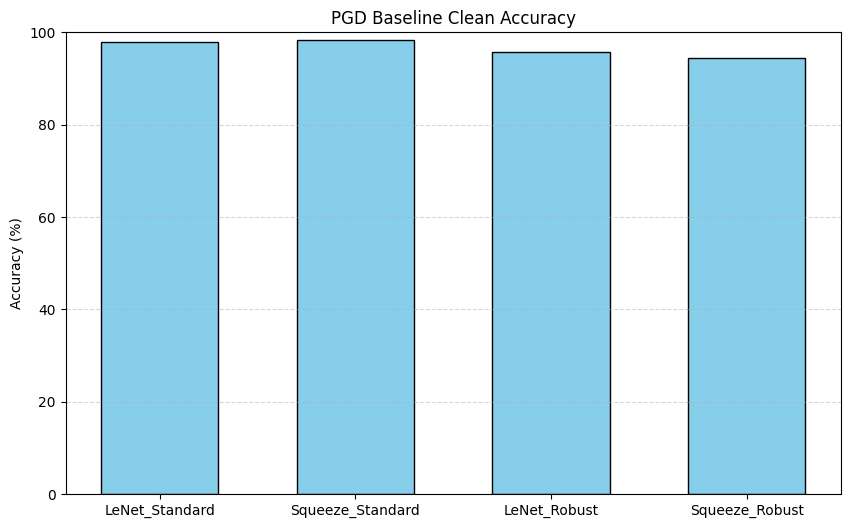

PGD Baseline Clean Accuracy:
  LeNet_Standard: 97.80%
  Squeeze_Standard: 98.20%
  LeNet_Robust: 95.80%
  Squeeze_Robust: 94.40%
------------------------------


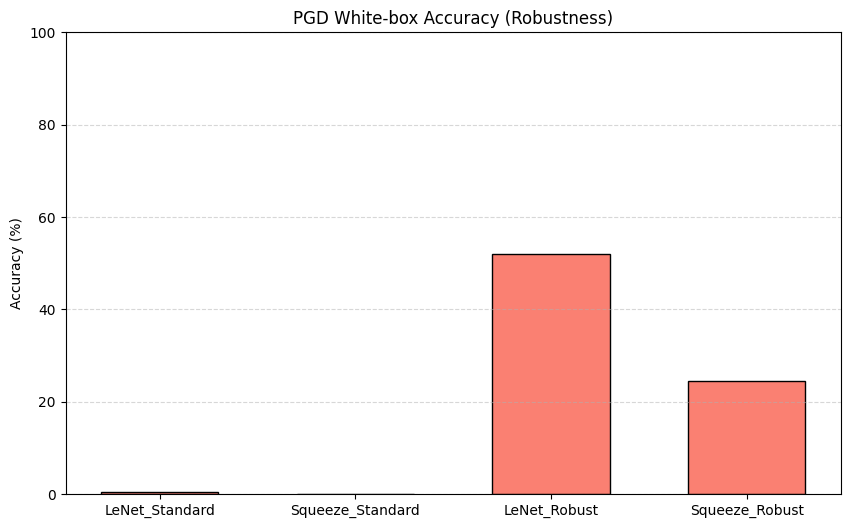

PGD White-box Robustness:
  LeNet_Standard: 0.40%
  Squeeze_Standard: 0.00%
  LeNet_Robust: 52.00%
  Squeeze_Robust: 24.40%
------------------------------


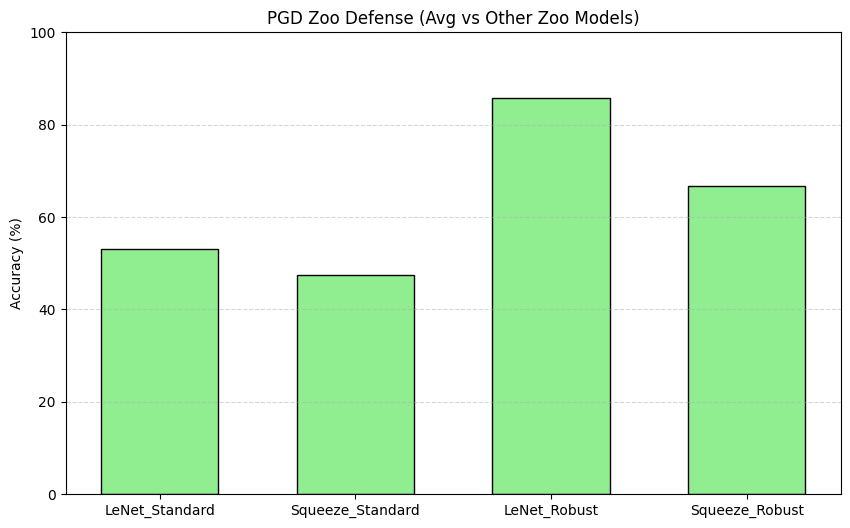

PGD Zoo Defense:
  LeNet_Standard: 52.98%
  Squeeze_Standard: 47.46%
  LeNet_Robust: 85.84%
  Squeeze_Robust: 66.64%
------------------------------


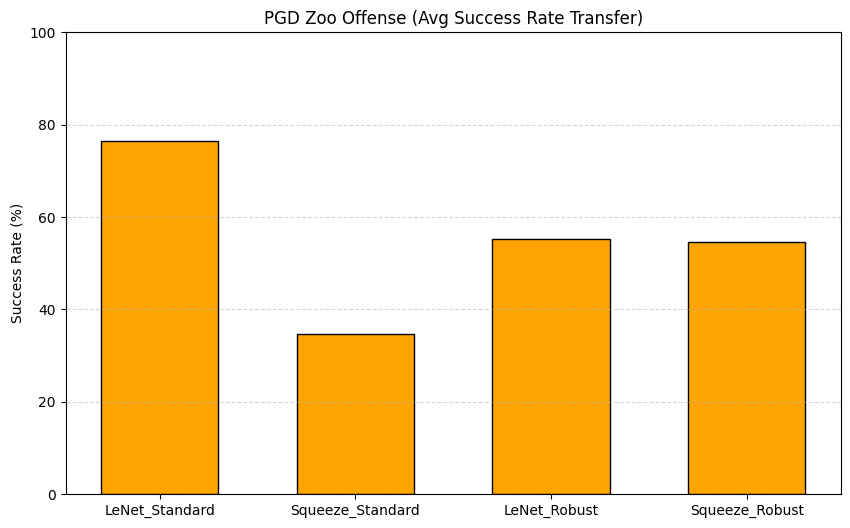

PGD Zoo Offense (Success Rate):
  LeNet_Standard: 76.40%
  Squeeze_Standard: 34.61%
  LeNet_Robust: 55.12%
  Squeeze_Robust: 54.56%
------------------------------


ValueError: too many values to unpack (expected 2)

<Figure size 1200x600 with 0 Axes>

In [60]:
pgd_metrics = calculate_metrics('PGD')

if pgd_metrics:
    x = np.arange(len(focus_models_names))
    width = 0.6

    # 1. Baseline Clean
    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['clean'], color='skyblue', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("PGD Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("PGD Baseline Clean Accuracy:")
    for n, v in zip(focus_models_names, pgd_metrics['clean']):
        print(f"  {n}: {v:.2f}%")
    print("-" * 30)

    # 2. White-box
    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['white'], color='salmon', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("PGD White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("PGD White-box Robustness:")
    for n, v in zip(focus_models_names, pgd_metrics['white']):
        print(f"  {n}: {v:.2f}%")
    print("-" * 30)

    # 3. Zoo Defense
    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['zoo_def'], color='lightgreen', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("PGD Zoo Defense (Avg vs Other Zoo Models)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("PGD Zoo Defense:")
    for n, v in zip(focus_models_names, pgd_metrics['zoo_def']):
        print(f"  {n}: {v:.2f}%")
    print("-" * 30)

    # 4. Zoo Offense
    plt.figure(figsize=(10, 6))
    plt.bar(x, pgd_metrics['zoo_off'], color='orange', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("PGD Zoo Offense (Avg Success Rate Transfer)")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("PGD Zoo Offense (Success Rate):")
    for n, v in zip(focus_models_names, pgd_metrics['zoo_off']):
        print(f"  {n}: {v:.2f}%")
    print("-" * 30)

    # 5. External Black Box
    if 'external_scores_map' in locals() and external_scores_map:
        x_ext = np.arange(len(focus_models_names))
        width_ext = 0.8 / len(external_scores_map)
        plt.figure(figsize=(12, 6))

        # Determine average scores for printing
        avg_ext_scores = np.zeros(len(focus_models_names))
        count = 0

        for i, (d_name, (imgs, lbls)) in enumerate(external_scores_map.items()):
            imgs = imgs.to(device); lbls = lbls.to(device)
            scores = []
            for name in focus_models_names:
                if name in zoo_models:
                    with torch.no_grad():
                        acc = (zoo_models[name](imgs).argmax(1) == lbls).float().mean().item() * 100
                        scores.append(acc)
                else: scores.append(0)

            plt.bar(x_ext + i*width_ext, scores, width_ext, label=d_name, edgecolor='black')
            avg_ext_scores += np.array(scores)
            count += 1

        avg_ext_scores /= max(1, count)

        plt.xticks(x_ext + width_ext * (len(external_scores_map)-1)/2, focus_models_names)
        plt.title("PGD: Robustness Against External (Black-Box) Datasets")
        plt.ylabel("Accuracy (%)")
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()

        print("PGD External Black-Box Robustness (Average across datasets):")
        for n, v in zip(focus_models_names, avg_ext_scores):
            print(f"  {n}: {v:.2f}%")
        print("-" * 30)

    # 6. Heatmap
    focus_indices = [all_names.index(n) for n in focus_models_names]
    sub_matrix = pgd_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=focus_models_names, yticklabels=focus_models_names)
    plt.title("PGD Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Building Matrix: 100%|██████████| 28/28 [00:01<00:00, 22.33it/s]


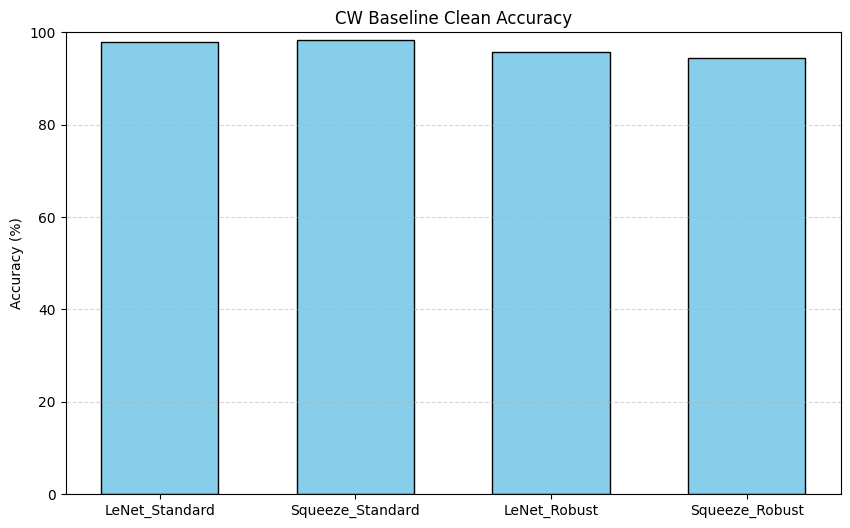

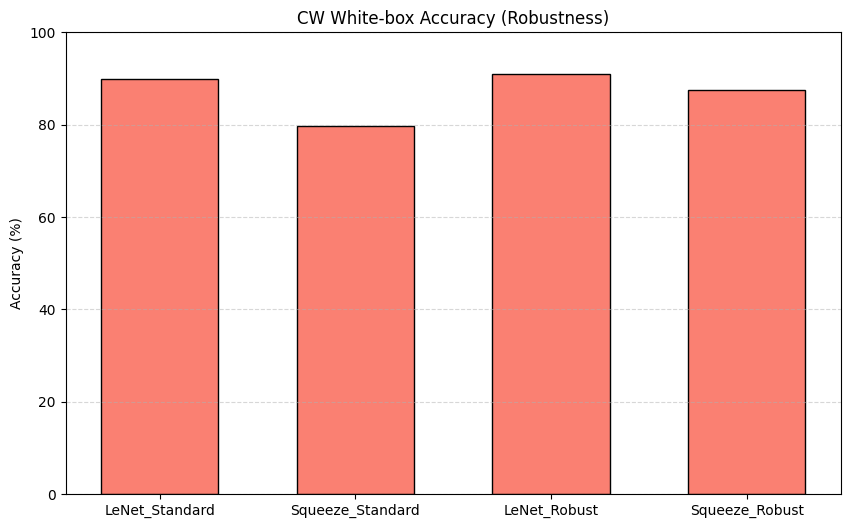

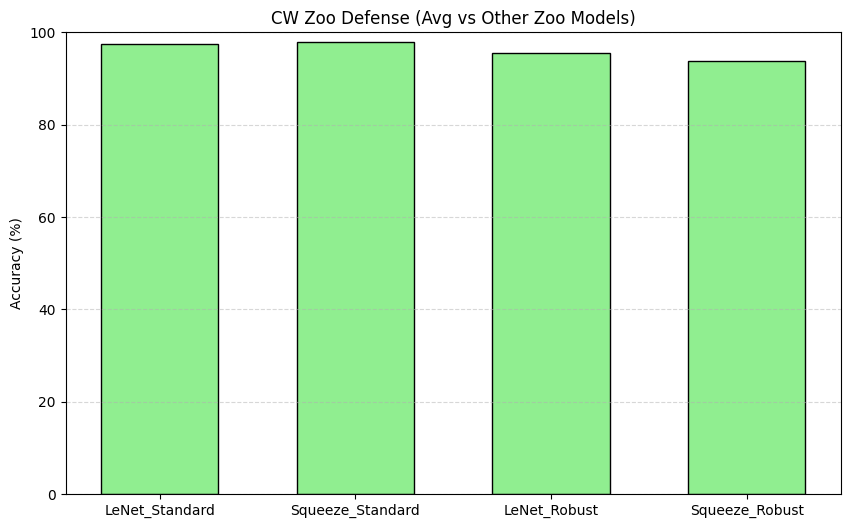

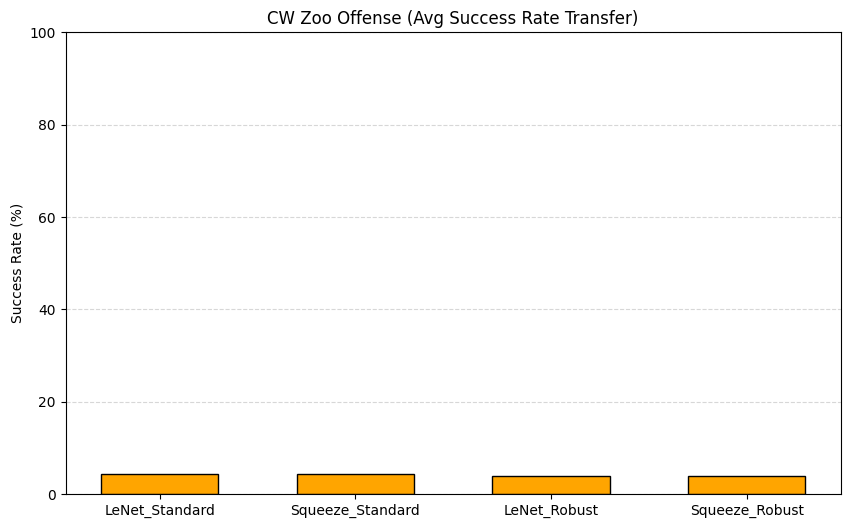

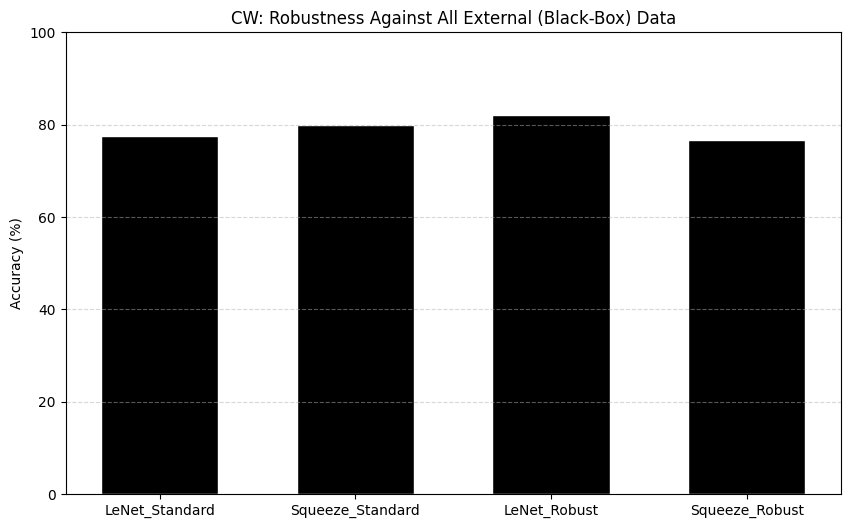

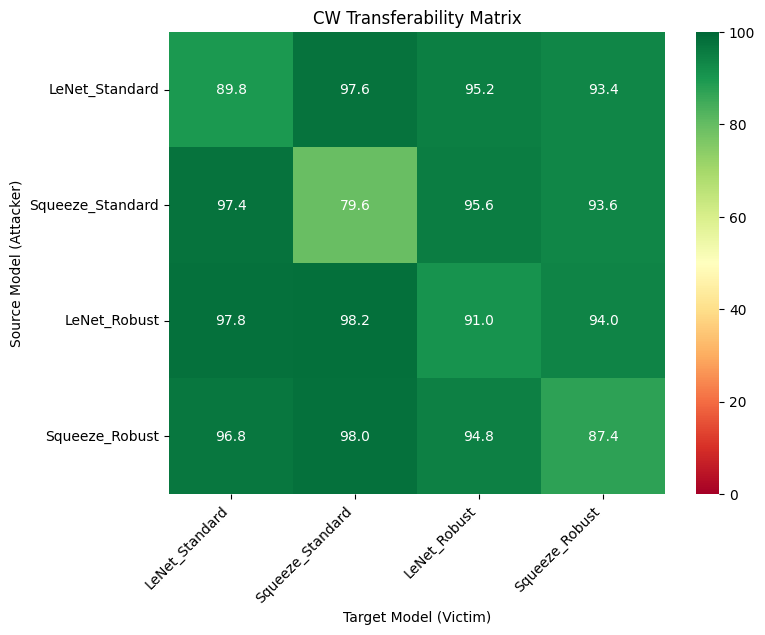

In [57]:
cw_metrics = calculate_metrics('CW')

if cw_metrics:
    x = np.arange(len(focus_models_names))
    width = 0.6

    plt.figure(figsize=(10, 6))
    plt.bar(x, cw_metrics['clean'], color='skyblue', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("CW Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, cw_metrics['white'], color='salmon', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("CW White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, cw_metrics['zoo_def'], color='lightgreen', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("CW Zoo Defense (Avg vs Other Zoo Models)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, cw_metrics['zoo_off'], color='orange', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("CW Zoo Offense (Avg Success Rate Transfer)")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, ext_accs, color='black', edgecolor='white', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("CW: Robustness Against All External (Black-Box) Data")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    focus_indices = [all_names.index(n) for n in focus_models_names]
    sub_matrix = cw_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=focus_models_names, yticklabels=focus_models_names)
    plt.title("CW Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Building Matrix: 100%|██████████| 28/28 [00:01<00:00, 22.51it/s]


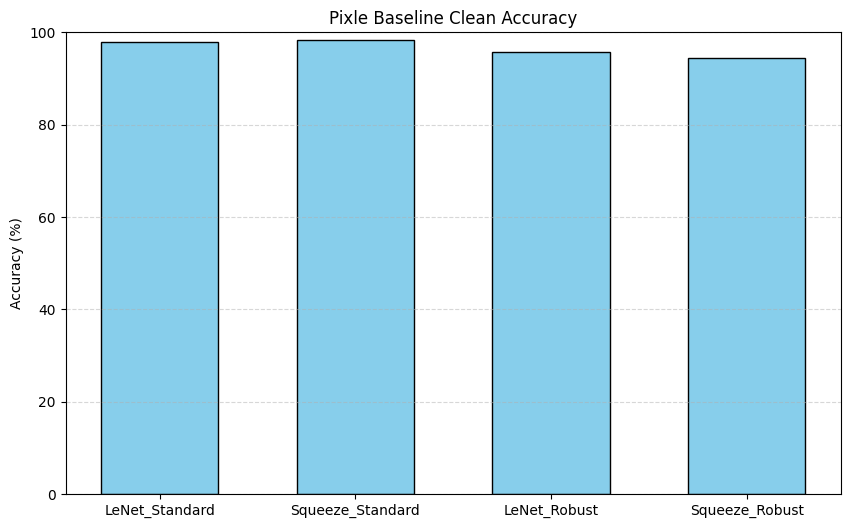

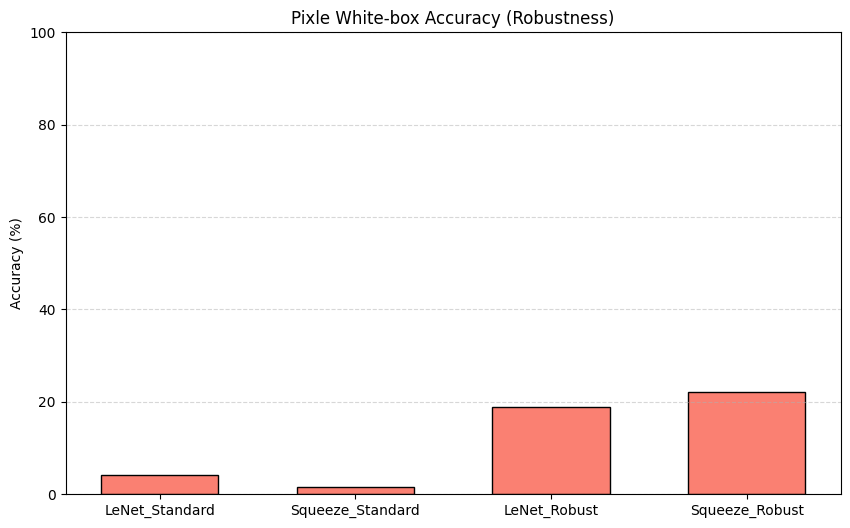

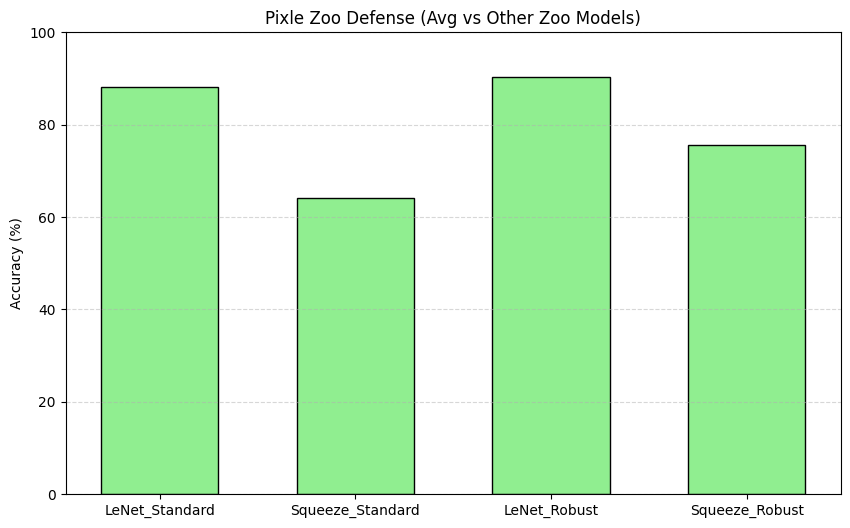

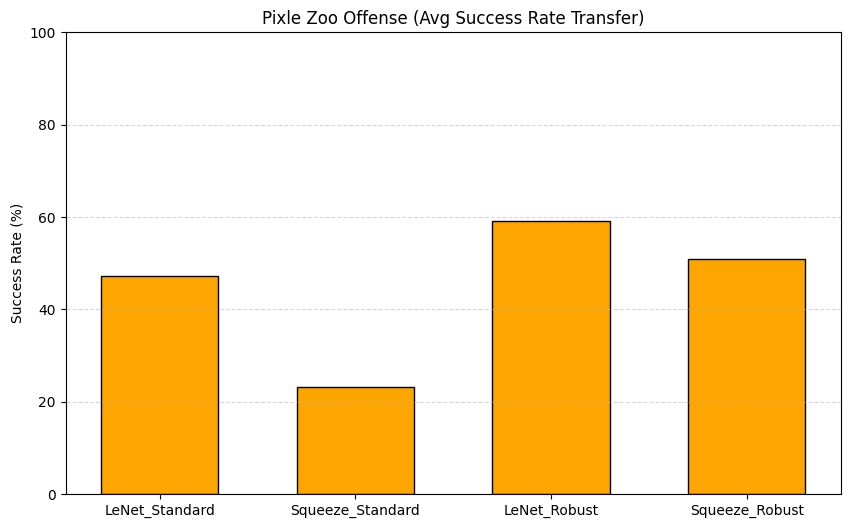

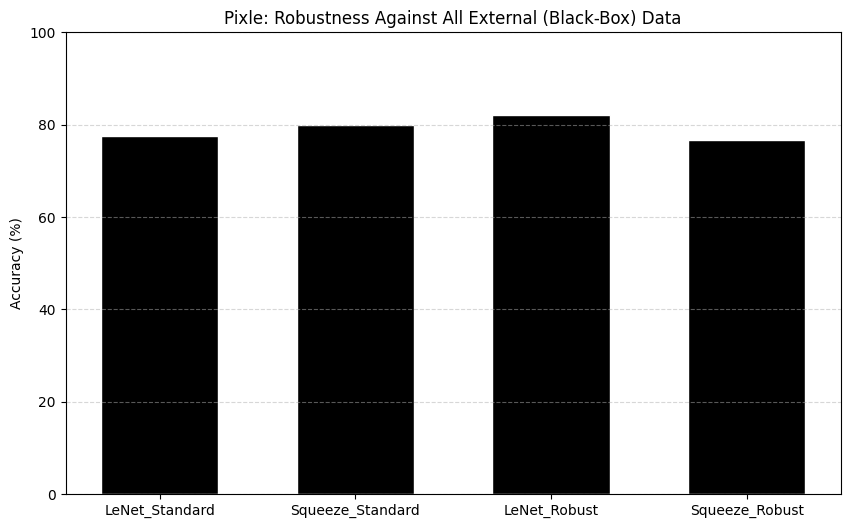

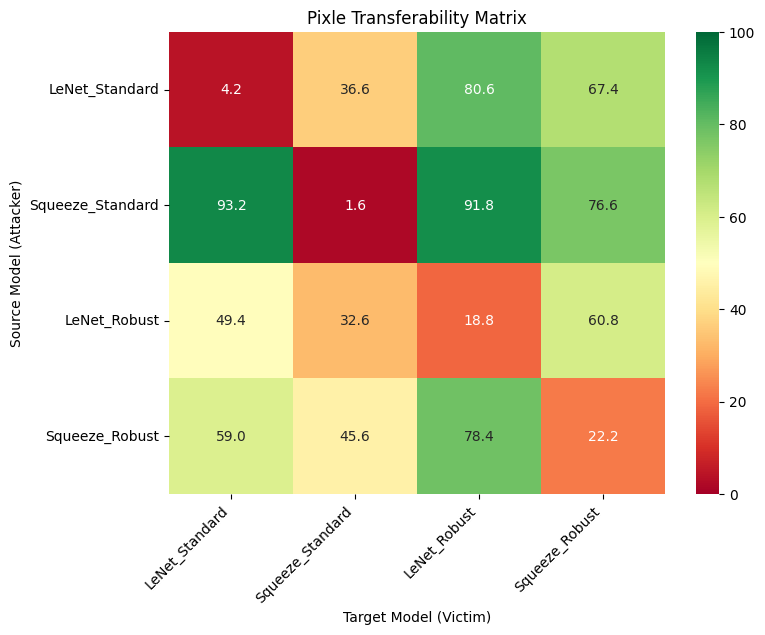

In [58]:
pixle_metrics = calculate_metrics('Pixle')

if pixle_metrics:
    x = np.arange(len(focus_models_names))
    width = 0.6

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['clean'], color='skyblue', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("Pixle Baseline Clean Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['white'], color='salmon', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("Pixle White-box Accuracy (Robustness)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['zoo_def'], color='lightgreen', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("Pixle Zoo Defense (Avg vs Other Zoo Models)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, pixle_metrics['zoo_off'], color='orange', edgecolor='black', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("Pixle Zoo Offense (Avg Success Rate Transfer)")
    plt.ylabel("Success Rate (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(x, ext_accs, color='black', edgecolor='white', width=width)
    plt.xticks(x, focus_models_names)
    plt.title("Pixle: Robustness Against All External (Black-Box) Data")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    focus_indices = [all_names.index(n) for n in focus_models_names]
    sub_matrix = pixle_metrics['matrix'][np.ix_(focus_indices, focus_indices)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
                xticklabels=focus_models_names, yticklabels=focus_models_names)
    plt.title("Pixle Transferability Matrix")
    plt.xlabel("Target Model (Victim)")
    plt.ylabel("Source Model (Attacker)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

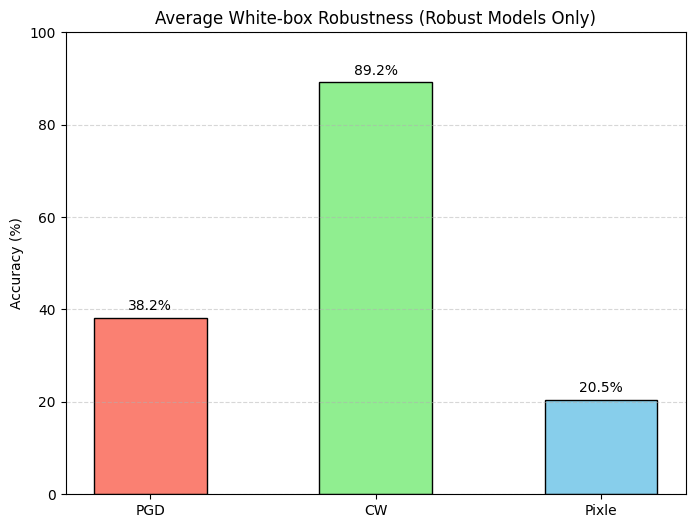

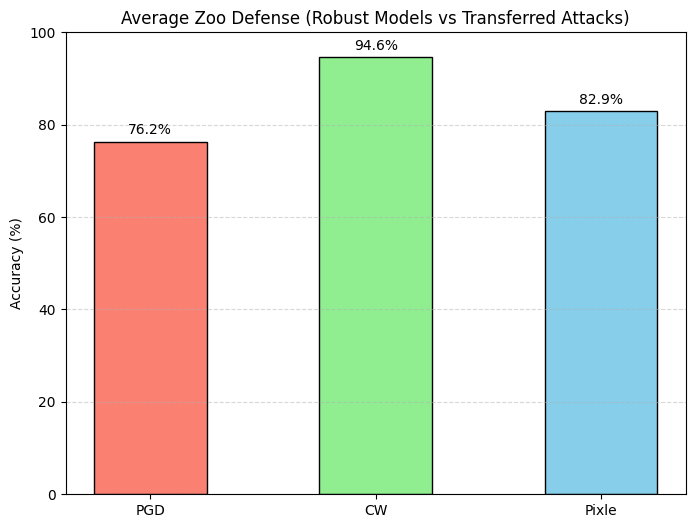

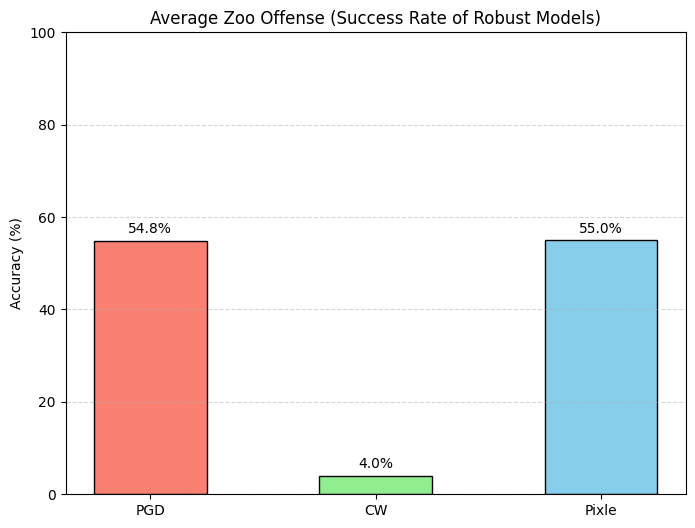

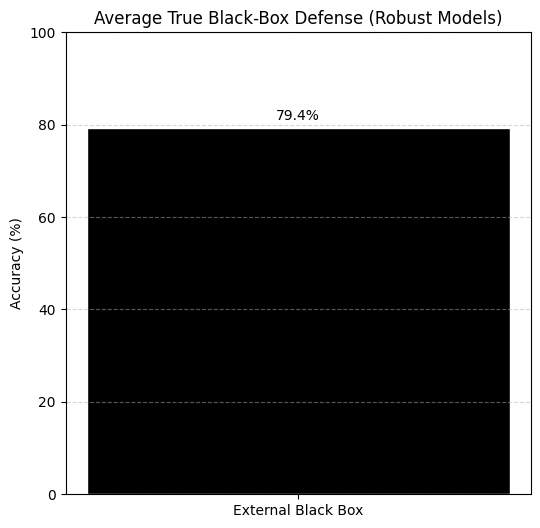

In [59]:
metrics_list = [pgd_metrics, cw_metrics, pixle_metrics]
attack_names = ['PGD', 'CW', 'Pixle']

rob_indices = [2, 3]

if all(m is not None for m in metrics_list):

    def plot_robust_algo_summary(key, title, ylabel="Accuracy (%)"):
        avg_scores = []
        for metrics in metrics_list:
            rob_scores = [metrics[key][i] for i in rob_indices]
            avg_scores.append(np.mean(rob_scores))

        plt.figure(figsize=(8, 6))
        bars = plt.bar(attack_names, avg_scores, color=['salmon', 'lightgreen', 'skyblue'], edgecolor='black', width=0.5)

        plt.title(title)
        plt.ylabel(ylabel)
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

        plt.show()

    plot_robust_algo_summary('white', "Average White-box Robustness (Robust Models Only)")
    plot_robust_algo_summary('zoo_def', "Average Zoo Defense (Robust Models vs Transferred Attacks)")
    plot_robust_algo_summary('zoo_off', "Average Zoo Offense (Success Rate of Robust Models)")

    rob_ext_avg = np.mean([ext_accs[i] for i in rob_indices])
    plt.figure(figsize=(6, 6))
    plt.bar(["External Black Box"], [rob_ext_avg], color='black', edgecolor='white', width=0.4)
    plt.title("Average True Black-Box Defense (Robust Models)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.text(0, rob_ext_avg + 1, f"{rob_ext_avg:.1f}%", ha='center', va='bottom')
    plt.show()